In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [296]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn import preprocessing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer as Imputer

from sklearn.pipeline import Pipeline

In [323]:
def dropthenan(table):
    cond1 = table[table.cfbconference == 'Other'].index.tolist()
    cond2 = table[table.cfbtd.isna()].index.tolist()
    cond3 = table[table.combineforty.isna()].index.tolist()
#    cond = np.unique(cond1+cond2+cond3)
    cond = np.intersect1d(np.intersect1d(cond1,cond2),cond3)
    return table.drop(cond, axis = 0).reset_index(drop = True)

def confclass(table):
    table.loc[table.cfbconference == 'Other','cfbconference'] = np.nan
    table.loc[table.cfbclass == 'Non Declared','cfbclass'] = np.nan
    table = pd.get_dummies(table, prefix=['cfbconference','cfbclass'])
    return table

def splitter(table, col, thresh):
    table['target'] = table[col].apply(lambda x: 1 if x > thresh else 0)
    return table.drop(col, axis = 1)

def splitter(arr, thresh):
    return arr.apply(lambda x: 1 if x > thresh else 0)

def normalizeX(X):
    x = X #returns a numpy array
    #trans = preprocessing.MinMaxScaler()
    trans = preprocessing.StandardScaler()
    x_scaled = trans.fit_transform(x)
    X_new = pd.DataFrame(x_scaled, columns = X.columns.tolist())
    return X_new

In [293]:
wr = pd.read_csv('data_sets/wr.csv')
wr = wr.rename(columns = {'yardsfirst5seasons': 'yffs'})
wr = wr.drop('combinebenchreps', axis = 1)

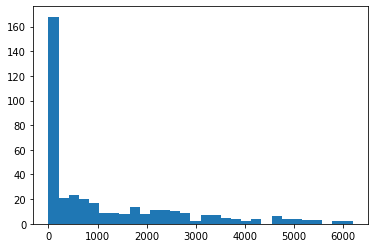

In [225]:
plt.hist(wrp.yffs, bins = 30)
plt.show()

### Threshold fixed

In [280]:
wr1 = dropthenan(wr)
wr1 = confclass(wr1)
wr1 = splitter(wr1, 'yffs', 5)

In [307]:
X = wr1.drop('target', axis = 1)
y = wr1.target

imp = Imputer(missing_values= np.nan, strategy = 'mean')
imp.fit(X)
X = imp.transform(X)
X = pd.DataFrame(X, columns = wr1.drop('target', axis = 1).columns.tolist())

X = normalizeX(X)

In [311]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, stratify = y)
knn = KNeighborsClassifier(n_neighbors = 18)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print('score',knn.score(X_test, y_test))
# print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

score 0.7946428571428571
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.79      1.00      0.89        89

    accuracy                           0.79       112
   macro avg       0.40      0.50      0.44       112
weighted avg       0.63      0.79      0.70       112



/Users/adriensaremi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 2 21]
 [12 77]]
              precision    recall  f1-score   support

           0       0.14      0.09      0.11        23
           1       0.79      0.87      0.82        89

    accuracy                           0.71       112
   macro avg       0.46      0.48      0.47       112
weighted avg       0.65      0.71      0.68       112



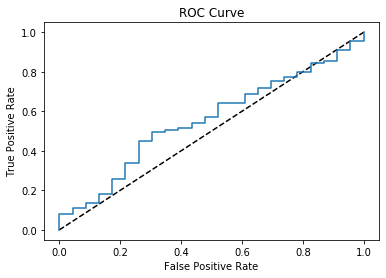

0.5544699560332194


In [312]:
logreg = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, stratify = y)

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print(roc_auc_score(y_test, y_pred_prob))

In [315]:
param_grid = {'n_neighbors':np.arange(1, 50)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv = 10)

knn_cv.fit(X, y)

print(knn_cv.best_params_)
print(knn_cv.best_score_)

{'n_neighbors': 18}
0.8016358463726887


In [292]:
# param_grid = {'C': np.logspace(-5, 8, 15)}
# logreg = LogisticRegression()
# logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# logreg_cv.fit(X, y)

# print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
# print("Best score is {}".format(logreg_cv.best_score_))

### Varying Threshold

In [324]:
wr2 = dropthenan(wr)
wr2 = confclass(wr2)
X = wr2.drop('yffs', axis = 1)
y = wr2.yffs

imp = Imputer(missing_values= np.nan, strategy = 'mean')
imp.fit(X)
X = imp.transform(X)
X = pd.DataFrame(X, columns = wr1.drop('target', axis = 1).columns.tolist())
X = normalizeX(X)

param_grid = {'n_neighbors':np.arange(1,30)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv = 10)

# bp_list=[]
# bs_list=[]

# for thresh in np.arange(1,10):
#     y = splitter(y, thresh)
#     knn_cv.fit(X, y)
#     bp_list.append(knn_cv.best_params_)
#     bs_list.append(knn_cv.best_score_)

In [328]:
y, splitter(y, 100)

(0      6171.0
 1      6201.0
 2       607.0
 3       990.0
 4      4254.0
         ...  
 368       0.0
 369       0.0
 370      11.0
 371     805.0
 372       0.0
 Name: yffs, Length: 373, dtype: float64, 0      1
 1      1
 2      1
 3      1
 4      1
       ..
 368    0
 369    0
 370    0
 371    1
 372    0
 Name: yffs, Length: 373, dtype: int64)